# **<변수선택기법 실습>**

# **전진/후진/단계적 변수선택법**

## **1. 로지스틱회귀분석을통한 변수선택법 실습**


로지스틱 회귀분석에서도 앞서 수행해본 회귀분석과 동일하게 변수선택법을 통해서 다양한 변수들의 조합을 통해서 최적의 모델을 적합 할 수가 있습니다.   
해당 부분을 **personal loan 데이터(binary classification)**를 이용해서 실습을 진행해보도록 하겠습니다.

## 모듈불러오기

In [1]:
%matplotlib inline
# 분석에 필요한 패키지 불러오기
import os
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
import statsmodels.api as sm
import matplotlib.pyplot as plt
import itertools
import time
import sklearn.preprocessing as preprocessing
import seaborn as sns

## 데이터불러오기

In [2]:
ploan = pd.read_csv("./data/Personal Loan.csv")
print( ploan.head(10) )

   ID  Age  Experience  Income  ZIP Code  Family  CCAvg  Education  Mortgage  \
0   1   25           1      49     91107       4    1.6          1         0   
1   2   45          19      34     90089       3    1.5          1         0   
2   3   39          15      11     94720       1    1.0          1         0   
3   4   35           9     100     94112       1    2.7          2         0   
4   5   35           8      45     91330       4    1.0          2         0   
5   6   37          13      29     92121       4    0.4          2       155   
6   7   53          27      72     91711       2    1.5          2         0   
7   8   50          24      22     93943       1    0.3          3         0   
8   9   35          10      81     90089       3    0.6          2       104   
9  10   34           9     180     93023       1    8.9          3         0   

   Personal Loan  Securities Account  CD Account  Online  CreditCard  
0              0                   1           0

## **데이터 전처리**

#### **['ID','ZIP Code']** 와 같은 명목형 자료의 경우 본 데이터의 목적에 부합하는 변수가 아니라고 판단하여 이를 제거 하겠습니다.

In [3]:
# 의미없는 변수 제거
ploan_processed = ploan.dropna().drop(['ID','ZIP Code'], axis=1, inplace=False)

## **상수항 추가**

#### 로지스틱 회귀분석에 있어서 상수(절편)에 해당하는 회귀계수를 알아가기 위해서 상수 변수를 추가하겠습니다.

In [4]:
ploan_processed = sm.add_constant(ploan_processed, has_constant='add')
print(ploan_processed.head(10) )

   const  Age  Experience  Income  Family  CCAvg  Education  Mortgage  \
0    1.0   25           1      49       4    1.6          1         0   
1    1.0   45          19      34       3    1.5          1         0   
2    1.0   39          15      11       1    1.0          1         0   
3    1.0   35           9     100       1    2.7          2         0   
4    1.0   35           8      45       4    1.0          2         0   
5    1.0   37          13      29       4    0.4          2       155   
6    1.0   53          27      72       2    1.5          2         0   
7    1.0   50          24      22       1    0.3          3         0   
8    1.0   35          10      81       3    0.6          2       104   
9    1.0   34           9     180       1    8.9          3         0   

   Personal Loan  Securities Account  CD Account  Online  CreditCard  
0              0                   1           0       0           0  
1              0                   1           0      

## 설명변수(X), 타켓변수(Y) 분리 및 학습데이터와 평가데이터 

In [5]:
feature_columns = list(ploan_processed.columns.difference(["Personal Loan"]))
X = ploan_processed[feature_columns]
y = ploan_processed['Personal Loan'] # 대출여부: 1 or 0

In [6]:
train_x, test_x, train_y, test_y = train_test_split(X, y, stratify=y,train_size=0.7,test_size=0.3,random_state=42)
print(train_x.shape, test_x.shape, train_y.shape, test_y.shape)

(1750, 12) (750, 12) (1750,) (750,)


In [7]:
ploan_processed.dtypes

const                 float64
Age                     int64
Experience              int64
Income                  int64
Family                  int64
CCAvg                 float64
Education               int64
Mortgage                int64
Personal Loan           int64
Securities Account      int64
CD Account              int64
Online                  int64
CreditCard              int64
dtype: object

In [8]:
feature_columns = list(ploan_processed.columns.difference(["Personal Loan"]))
X = ploan_processed[feature_columns]
y = ploan_processed['Personal Loan'] 
train_x, test_x, train_y, test_y = train_test_split(X, y, stratify=y,train_size=0.7,test_size=0.3,random_state=123)
print(train_x.shape, test_x.shape, train_y.shape, test_y.shape)

(1750, 12) (750, 12) (1750,) (750,)


<img src = "./fig/1_전진선택법.PNG" width="60%">

In [9]:
def processSubset(X,y, feature_set):
            model = sm.Logit(y,X[list(feature_set)])
            regr = model.fit()
            AIC = regr.aic
            return {"model":regr, "AIC":AIC}
        
'''
전진선택법
'''
def forward(X, y, predictors):
    # 데이터 변수들이 미리정의된 predictors에 있는지 없는지 확인 및 분류
    remaining_predictors = [p for p in X.columns.difference(['const']) if p not in predictors]
    tic = time.time()
    results = []
    for p in remaining_predictors:
        results.append(processSubset(X=X, y= y, feature_set=predictors+[p]+['const']))
    # 데이터프레임으로 변환
    models = pd.DataFrame(results)

    # AIC가 가장 낮은 것을 선택
    best_model = models.loc[models['AIC'].argmin()] # index
    toc = time.time()
    print("Processed ", models.shape[0], "models on", len(predictors)+1, "predictors in", (toc-tic))
    print('Selected predictors:',best_model['model'].model.exog_names,' AIC:',best_model[0] )
    return best_model

def forward_model(X,y):
    Fmodels = pd.DataFrame(columns=["AIC", "model"])
    tic = time.time()
    # 미리 정의된 데이터 변수
    predictors = []
    # 변수 1~10개 : 0~9 -> 1~10
    for i in range(1, len(X.columns.difference(['const'])) + 1):
        Forward_result = forward(X=X,y=y,predictors=predictors)
        if i > 1:
            if Forward_result['AIC'] > Fmodel_before:
                break
        Fmodels.loc[i] = Forward_result
        predictors = Fmodels.loc[i]["model"].model.exog_names
        Fmodel_before = Fmodels.loc[i]["AIC"]
        predictors = [ k for k in predictors if k != 'const']
    toc = time.time()
    print("Total elapsed time:", (toc - tic), "seconds.")

    return(Fmodels['model'][len(Fmodels['model'])])


<img src = "./fig/2_후진소거법.PNG" width="60%">

In [10]:
'''
후진소거법
'''
def backward(X,y,predictors):
    tic = time.time()
    results = []
    
    # 데이터 변수들이 미리정의된 predictors 조합 확인
    for combo in itertools.combinations(predictors, len(predictors) - 1):
        results.append(processSubset(X=X, y= y,feature_set=list(combo)+['const']))
    models = pd.DataFrame(results)
    
    # 가장 낮은 AIC를 가진 모델을 선택
    best_model = models.loc[models['AIC'].argmin()]
    toc = time.time()
    print("Processed ", models.shape[0], "models on", len(predictors) - 1, "predictors in",
          (toc - tic))
    print('Selected predictors:',best_model['model'].model.exog_names,' AIC:',best_model[0] )
    return best_model


def backward_model(X, y):
    Bmodels = pd.DataFrame(columns=["AIC", "model"], index = range(1,len(X.columns)))
    tic = time.time()
    predictors = X.columns.difference(['const'])
    Bmodel_before = processSubset(X,y,predictors)['AIC']
    while (len(predictors) > 1):
        Backward_result = backward(X=train_x, y= train_y, predictors = predictors)
        if Backward_result['AIC'] > Bmodel_before:
            break
        Bmodels.loc[len(predictors) - 1] = Backward_result
        predictors = Bmodels.loc[len(predictors) - 1]["model"].model.exog_names
        Bmodel_before = Backward_result['AIC']
        predictors = [ k for k in predictors if k != 'const']

    toc = time.time()
    print("Total elapsed time:", (toc - tic), "seconds.")
    return (Bmodels['model'].dropna().iloc[0])



<img src = "./fig/3_단계적선택법.PNG" width="60%">

In [11]:
'''
단계적 선택법
'''
def Stepwise_model(X,y):
    Stepmodels = pd.DataFrame(columns=["AIC", "model"])
    tic = time.time()
    predictors = []
    Smodel_before = processSubset(X,y,predictors+['const'])['AIC']
    # 변수 1~10개 : 0~9 -> 1~10
    for i in range(1, len(X.columns.difference(['const'])) + 1):
        Forward_result = forward(X=X, y=y, predictors=predictors) # constant added
        print('forward')
        Stepmodels.loc[i] = Forward_result
        predictors = Stepmodels.loc[i]["model"].model.exog_names
        predictors = [ k for k in predictors if k != 'const']
        Backward_result = backward(X=X, y=y, predictors=predictors)
        if Backward_result['AIC']< Forward_result['AIC']:
            Stepmodels.loc[i] = Backward_result
            predictors = Stepmodels.loc[i]["model"].model.exog_names
            Smodel_before = Stepmodels.loc[i]["AIC"]
            predictors = [ k for k in predictors if k != 'const']
            print('backward')
        if Stepmodels.loc[i]['AIC']> Smodel_before:
            break
        else:
            Smodel_before = Stepmodels.loc[i]["AIC"]
    toc = time.time()
    print("Total elapsed time:", (toc - tic), "seconds.")
    return (Stepmodels['model'][len(Stepmodels['model'])])

In [12]:
Forward_best_model = forward_model(X=train_x, y= train_y)

Optimization terminated successfully.
         Current function value: 0.330074
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.278922
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.299636
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.330053
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.320022
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.330073
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.328654
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.211066
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.325250
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.330069
  

In [13]:
Backward_best_model = backward_model(X=train_x,y=train_y)

Optimization terminated successfully.
         Current function value: 0.141184
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.139171
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.136647
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.136190
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.214321
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.146923
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.136155
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.167931
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.139247
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.152001
  

In [14]:
Stepwise_best_model = Stepwise_model(X=train_x,y=train_y)

Optimization terminated successfully.
         Current function value: 0.330076
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.330074
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.278922
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.299636
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.330053
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.320022
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.330073
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.328654
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.211066
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.325250
  

## Target의 확률 추정

In [15]:
# 모델에 의해 예측된/추정된 값 <->  test_y

# 모델 구축 및 학습
model = sm.Logit(train_y, train_x)
results = model.fit(method='newton')
pred_y_full = results.predict(test_x) # full model

pred_y_forward = Forward_best_model.predict(test_x[Forward_best_model.model.exog_names])
pred_y_backward = Backward_best_model.predict(test_x[Backward_best_model.model.exog_names])
pred_y_stepwise = Stepwise_best_model.predict(test_x[Stepwise_best_model.model.exog_names])


Optimization terminated successfully.
         Current function value: 0.136053
         Iterations 9


## Best cut-off를 사용하여 범주형으로 변환

In [16]:
def plot_ROC(y_train_true, y_train_prob, y_test_true, y_test_prob):
    '''
    a funciton to plot the ROC curve for train labels and test labels.
    Use the best threshold found in train set to classify items in test set.
    '''
    fpr_train, tpr_train, thresholds_train = roc_curve(y_train_true, y_train_prob, pos_label =True)
    
    sum_sensitivity_specificity_train = tpr_train + (1-fpr_train)
    
    best_threshold_id_train = np.argmax(sum_sensitivity_specificity_train)
    best_threshold = thresholds_train[best_threshold_id_train]
    best_fpr_train = fpr_train[best_threshold_id_train]
    best_tpr_train = tpr_train[best_threshold_id_train]
    y_train = y_train_prob > best_threshold

    cm_train = confusion_matrix(y_train_true, y_train)
    acc_train = accuracy_score(y_train_true, y_train)
    auc_train = roc_auc_score(y_train_true, y_train)

    print('Train Accuracy: %s ' %acc_train)
    print('Train AUC: %s ' %auc_train)
    print('Train Confusion Matrix:')
    print(cm_train)

    
    # Plotting ROC Curve for Train 
    fig = plt.figure(figsize=(15,7))
    ax = fig.add_subplot(121)
    curve1 = ax.plot(fpr_train, tpr_train)
    curve2 = ax.plot([0, 1], [0, 1], color='navy', linestyle='--')
    dot = ax.plot(best_fpr_train, best_tpr_train, marker='o', color='black')
    ax.text(best_fpr_train, best_tpr_train, s = '(%.3f,%.3f)' %(best_fpr_train, best_tpr_train))
    plt.xlim([-0.01, 1.01])
    plt.ylim([-0.01, 1.01])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve (Train), AUC = %.4f'%auc_train)

    fpr_test, tpr_test, thresholds_test = roc_curve(y_test_true, y_test_prob, pos_label =True)

    y_test = y_test_prob > best_threshold

    cm_test = confusion_matrix(y_test_true, y_test)
    acc_test = accuracy_score(y_test_true, y_test)
    auc_test = roc_auc_score(y_test_true, y_test)

    print('Test Accuracy: %s ' %acc_test)
    print('Test AUC: %s ' %auc_test)
    print('Test Confusion Matrix:')
    print(cm_test)

    tpr_score = float(cm_test[1][1])/(cm_test[1][1] + cm_test[1][0])
    fpr_score = float(cm_test[0][1])/(cm_test[0][0]+ cm_test[0][1])
    
    # Plotting ROC Curve for Test 
    ax2 = fig.add_subplot(122)
    curve1 = ax2.plot(fpr_test, tpr_test)
    curve2 = ax2.plot([0, 1], [0, 1], color='navy', linestyle='--')
    dot = ax2.plot(fpr_score, tpr_score, marker='o', color='black')
    ax2.text(fpr_score, tpr_score, s = '(%.3f,%.3f)' %(fpr_score, tpr_score))
    plt.xlim([-0.01, 1.01])
    plt.ylim([-0.01, 1.01])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve (Test), AUC = %.4f'%auc_test)
    plt.savefig('ROC', dpi = 500)
    plt.show()

    return best_threshold

Train Accuracy: 0.8628571428571429 
Train AUC: 0.8914401743898666 
Train Confusion Matrix:
[[1344  227]
 [  13  166]]
Test Accuracy: 0.8586666666666667 
Test AUC: 0.8694930626579958 
Test Confusion Matrix:
[[576  97]
 [  9  68]]


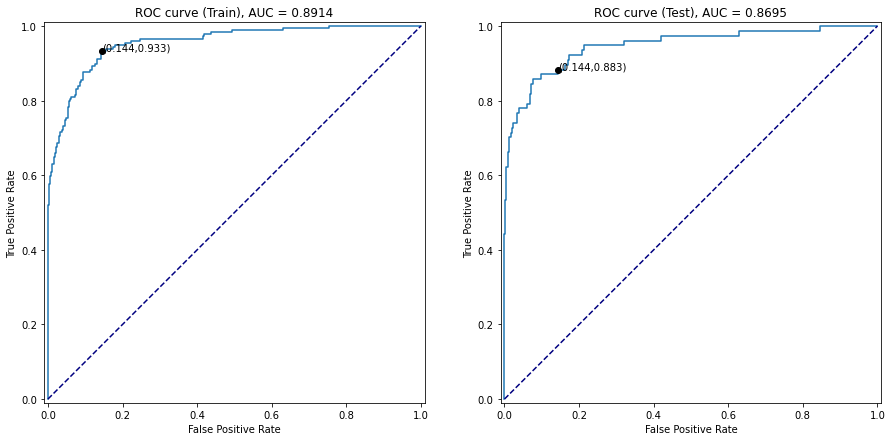

In [17]:
BestThreshold_full= plot_ROC(y_train_true=train_y, y_train_prob=results.predict(train_x),
         y_test_true=test_y, y_test_prob=results.predict(test_x))

Train Accuracy: 0.892 
Train AUC: 0.8903466816495915 
Train Confusion Matrix:
[[1402  169]
 [  20  159]]
Test Accuracy: 0.8973333333333333 
Test AUC: 0.8852878176800911 
Test Confusion Matrix:
[[606  67]
 [ 10  67]]


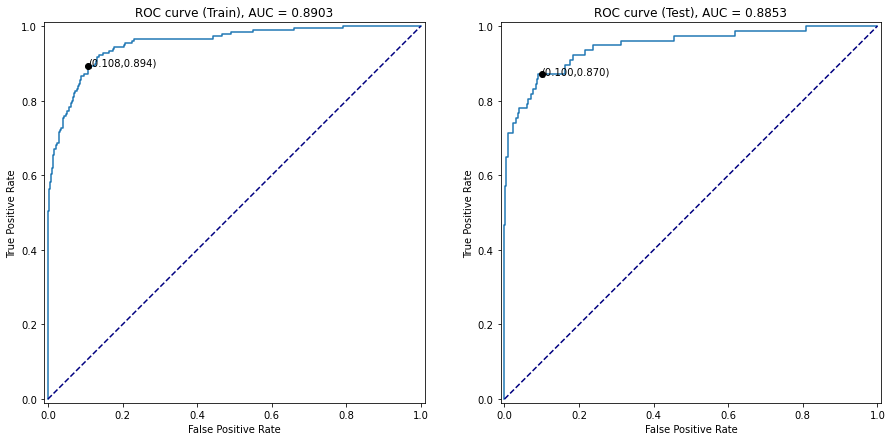

In [18]:
BestThreshold_forward = plot_ROC(train_y,Forward_best_model.predict(train_x[Forward_best_model.model.exog_names]),
                                 test_y,Forward_best_model.predict(test_x[Forward_best_model.model.exog_names]))

Train Accuracy: 0.892 
Train AUC: 0.8903466816495915 
Train Confusion Matrix:
[[1402  169]
 [  20  159]]
Test Accuracy: 0.8973333333333333 
Test AUC: 0.8852878176800911 
Test Confusion Matrix:
[[606  67]
 [ 10  67]]


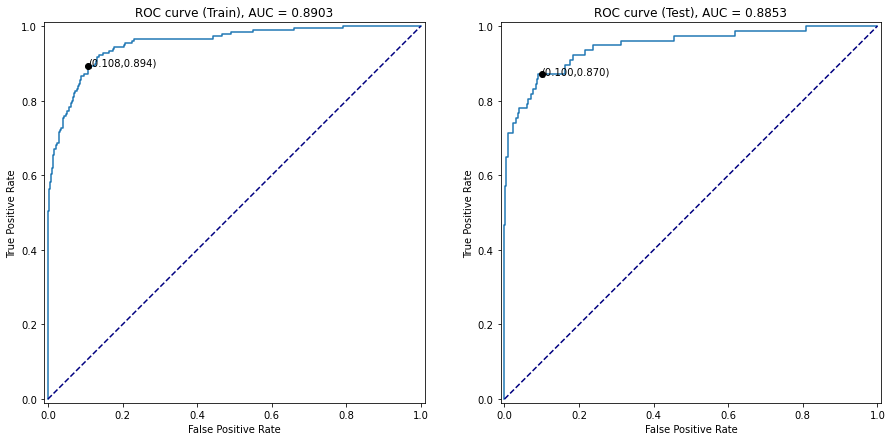

In [19]:
BestThreshold_backward = plot_ROC(train_y,Backward_best_model.predict(train_x[Backward_best_model.model.exog_names]),
                                 test_y,Backward_best_model.predict(test_x[Backward_best_model.model.exog_names]))

Train Accuracy: 0.892 
Train AUC: 0.8903466816495915 
Train Confusion Matrix:
[[1402  169]
 [  20  159]]
Test Accuracy: 0.8973333333333333 
Test AUC: 0.8852878176800911 
Test Confusion Matrix:
[[606  67]
 [ 10  67]]


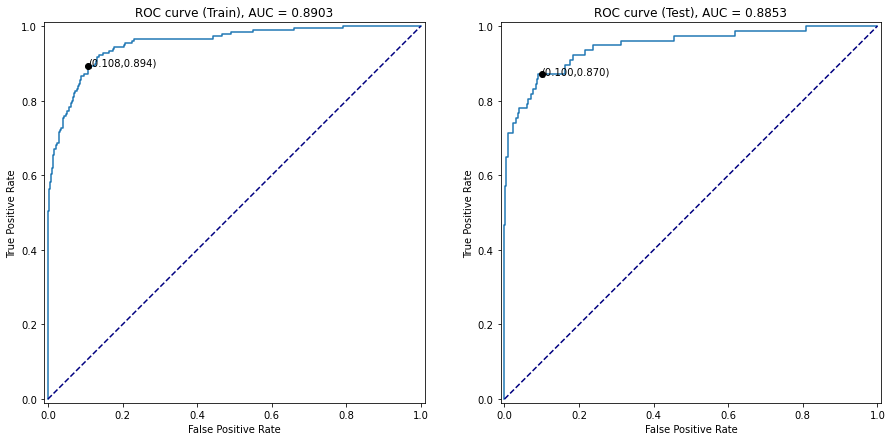

In [20]:
BestThreshold_stepwise = plot_ROC(train_y,Stepwise_best_model.predict(train_x[Stepwise_best_model.model.exog_names]),
                                 test_y,Stepwise_best_model.predict(test_x[Stepwise_best_model.model.exog_names]))

In [21]:
# Cut-off 정의
def cut_off(y, threshold):
    Y = y.copy() # copy함수를 사용하여 이전의 y값이 변화지 않게 함
    Y[y > threshold] = 1
    Y[y <= threshold] = 0
    return(Y.astype(int))

In [22]:
pred_Y_full= cut_off(pred_y_full,BestThreshold_full)
pred_Y_forward = cut_off(pred_y_forward,BestThreshold_forward)
pred_Y_backward = cut_off(pred_y_backward,BestThreshold_backward)
pred_Y_stepwise = cut_off(pred_y_stepwise,BestThreshold_stepwise)

## **혼동행렬으로 표현**

In [23]:
cfmat_full = confusion_matrix(test_y, pred_Y_full)
cfmat_forward = confusion_matrix(test_y, pred_Y_forward)
cfmat_backward = confusion_matrix(test_y, pred_Y_backward)
cfmat_stepwise = confusion_matrix(test_y, pred_Y_stepwise)

## **성능비교**

In [24]:
def perf_eval(cm):
    # True positive rate: TPR
    TPR = cm[1, 1] / sum(cm[1]) # recall
    # True negative rate: TNR
    TNR = cm[0, 0] / sum(cm[0])
    # Simple Accuracy
    ACC = (cm[0, 0] + cm[1, 1]) / sum(cm.reshape(-1,))
    # Balanced Correction Rate
    BCR = np.sqrt(TPR * TNR)
    # F1-measure
    Precision = cm[1,1] /sum(cm[:,1])
    F1 = 2*TPR*Precision/(TPR+Precision)
    return ([TPR, TNR, ACC, BCR, F1])

In [25]:
perf_mat = pd.DataFrame(columns=["TPR", "TNR", "ACC", "BCR","F1"],
                        index =['FULL', 'FORWARD','BACKWARD', 'STEPWISE'])


perf_mat.loc['FULL']=perf_eval(cfmat_full)
perf_mat.loc['FORWARD']=perf_eval(cfmat_forward)
perf_mat.loc['BACKWARD']=perf_eval(cfmat_backward)
perf_mat.loc['STEPWISE']=perf_eval(cfmat_stepwise)

In [26]:
perf_mat

,TPR,TNR,ACC,BCR,F1
FULL,0.883117,0.855869,0.858667,0.869386,0.561983
FORWARD,0.87013,0.900446,0.897333,0.885158,0.635071
BACKWARD,0.87013,0.900446,0.897333,0.885158,0.635071
STEPWISE,0.87013,0.900446,0.897333,0.885158,0.635071


In [27]:
print( perf_mat.loc['FORWARD','TNR'])

0.9004457652303121


In [28]:
print( perf_mat.iloc[:,1])

FULL        0.855869
FORWARD     0.900446
BACKWARD    0.900446
STEPWISE    0.900446
Name: TNR, dtype: object



## **2. 선형회귀분석을통한 변수선택법 실습**


#### **실습예제2 : 도요타 코롤라 중고차 가격 데이터셋**
다른 예제 데이터(중고차데이터:ToyotaCorolla 데이터셋)를 활용해서 변수선택법의 수행과정을 확인해보도록 하겠습니다.

- 사양에 따른 도요타 중고차 차량의 가격예측
- 사양정보에 따른 도요타 중고차 1,442대의 가격 데이터셋
- 사용된 변수들
    - 판매가격 (Euros)
    - 내용연수 (2004년 8월 현재)
    - 연비 (kilometers)
    - 연료유형 (diesel, petrol, CNG)
    - 마력 (horsepower)
    - 금속색상 (1=yes, 0=no)
    - 자동변속 (1=yes, 0=no)
    - 실린더 부피 (cylinder volume)
    - 자동차 문의 개수
    - 분기별 도로 사용세(road tax)
    - 무게 (kg)


##### 해당 변수들을 사용하기에 앞서서 **범주형 변수들은 이항변수로 변환**하는 과정이 필요합니다.
- Diesel (1=yes, 0=no)
- CNG (1=yes, 0=no)
- None needed for “Petrol” (reference category)

### 데이터 불러오기

In [95]:
# 데이터 불러오기
corolla = pd.read_csv("./data/ToyotaCorolla.csv")
print(corolla.head())

   Id                                           Model  Price  Age_08_04  \
0   1   TOYOTA Corolla 2.0 D4D HATCHB TERRA 2/3-Doors  13500         23   
1   2   TOYOTA Corolla 2.0 D4D HATCHB TERRA 2/3-Doors  13750         23   
2   3  ?TOYOTA Corolla 2.0 D4D HATCHB TERRA 2/3-Doors  13950         24   
3   4   TOYOTA Corolla 2.0 D4D HATCHB TERRA 2/3-Doors  14950         26   
4   5     TOYOTA Corolla 2.0 D4D HATCHB SOL 2/3-Doors  13750         30   

   Mfg_Month  Mfg_Year     KM Fuel_Type  HP  Met_Color  ...  Central_Lock  \
0         10      2002  46986    Diesel  90          1  ...             1   
1         10      2002  72937    Diesel  90          1  ...             1   
2          9      2002  41711    Diesel  90          1  ...             0   
3          7      2002  48000    Diesel  90          0  ...             0   
4          3      2002  38500    Diesel  90          0  ...             1   

   Powered_Windows  Power_Steering  Radio  Mistlamps  Sport_Model  \
0                

### 데이터 관측치 갯수(nCar)와 변수의 수(nVar) 확인

In [96]:
nCar = corolla.shape[0]
nVar = corolla.shape[1]
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 1436 nVar: 37


# 데이터 전처리

## 범주형 변수를 이진형 변수로 변환

In [97]:
# 가변수 생성
dummy_p = np.repeat(0,nCar)
dummy_d = np.repeat(0,nCar)
dummy_c = np.repeat(0,nCar)

In [98]:

# 연료타입에 대한 위치 인덱스를 저장  
p_idx = np.array(corolla.Fuel_Type == "Petrol")
d_idx = np.array(corolla.Fuel_Type == "Diesel")
c_idx = np.array(corolla.Fuel_Type == "CNG")

In [99]:
# 인덱스 슬라이싱 후 (binary = 1) 대입
dummy_p[p_idx] = 1  # Petrol
dummy_d[d_idx] = 1  # Diesel
dummy_c[c_idx] = 1  # CNG

## 불필요한 변수 제거 및 가변수 추가

In [100]:
# np or dict to DF
Fuel = pd.DataFrame({'Petrol': dummy_p, 'Diesel': dummy_d, 'CNG': dummy_c})

# column slice
corolla_ = corolla.dropna().drop(['Id','Model','Fuel_Type'], axis=1, inplace=False)
mlr_data = pd.concat((corolla_, Fuel), 1)

In [101]:
# bias 추가
mlr_data = sm.add_constant(mlr_data, has_constant='add')
mlr_data.head()

,const,Price,Age_08_04,Mfg_Month,Mfg_Year,KM,HP,Met_Color,Automatic,cc,...,Radio,Mistlamps,Sport_Model,Backseat_Divider,Metallic_Rim,Radio_cassette,Tow_Bar,Petrol,Diesel,CNG
0,1.0,13500,23,10,2002,46986,90,1,0,2000,...,0,0,0,1,0,0,0,0,1,0
1,1.0,13750,23,10,2002,72937,90,1,0,2000,...,0,0,0,1,0,0,0,0,1,0
2,1.0,13950,24,9,2002,41711,90,1,0,2000,...,0,0,0,1,0,0,0,0,1,0
3,1.0,14950,26,7,2002,48000,90,0,0,2000,...,0,0,0,1,0,0,0,0,1,0
4,1.0,13750,30,3,2002,38500,90,0,0,2000,...,0,1,0,1,0,0,0,0,1,0


## 설명변수(X), 타켓변수(Y) 분리 및 학습데이터와 평가데이터 

In [102]:
feature_columns = list(mlr_data.columns.difference(['Price']))
X = mlr_data[feature_columns]
y = mlr_data.Price
train_x, test_x, train_y, test_y = train_test_split(X, y, train_size=0.7, test_size=0.3, random_state=1)
print(train_x.shape, test_x.shape, train_y.shape, test_y.shape)

(1005, 37) (431, 37) (1005,) (431,)


# 선형회귀모형 모델링 y = f(x)

In [103]:
# Train the MLR
full_model = sm.OLS(train_y, train_x)
fitted_full_model = full_model.fit()

## 학습에 유의미한 변수확인

|Element|Description|
|:----|:-----------|
|Dep. Variable |	Which variable is the response in the model|
|Model|	What model you are using in the fit|
|Method|	How the parameters of the model were calculated|
|No. Observations|	The number of observations (examples)|
|DF Residuals|	Degrees of freedom of the residuals. Number of observations – number of parameters|
|DF Model|	Number of parameters in the model (not including the constant term if present)|
|R-squared|	The coefficient of determination. A statistical measure of how well the regression line approximates the real data points|
|Adj. R-squared|	The above value adjusted based on the number of observations and the degrees-of-freedom of the residuals|
|F-statistic|	A measure how significant the fit is. The mean squared error of the model divided by the mean squared error of the residuals|
|Prob (F-statistic)|	The probability that you would get the above statistic, given the null hypothesis that they are unrelated|
|Log-likelihood|	The log of the likelihood function.|
|AIC|	The Akaike Information Criterion. Adjusts the log-likelihood based on the number of observations and the complexity of the model.|
|BIC|	The Bayesian Information Criterion. Similar to the AIC, but has a higher penalty for models with more parameters.|


|Element|Description|
|:----|:-----------|
|coef|	The estimated value of the coefficient|
|std err|	The basic standard error of the estimate of the coefficient. More sophisticated errors are also available.|
|t	|The t-statistic value. This is a measure of how statistically significant the coefficient is.|
|P > ㅣtㅣ|	P-value that the null-hypothesis that the coefficient = 0 is true. If it is less than the confidence level, often 0.05, it indicates that there is a statistically significant relationship between the term and the response.|
|[95.0% Conf. Interval]|The lower and upper values of the 95% confidence interval|

|Element|Description|
|:----|:-----------|
|Skewness|	A measure of the symmetry of the data about the mean. Normally-distributed errors should be symmetrically distributed about the mean (equal amounts above and below the line).|
|Kurtosis|	A measure of the shape of the distribution. Compares the amount of data close to the mean with those far away from the mean (in the tails).|
|Omnibus|	D’Angostino’s test. It provides a combined statistical test for the presence of skewness and kurtosis.|
|Prob(Omnibus)|	The above statistic turned into a probability|
|Jarque-Bera|	A different test of the skewness and kurtosis|
|Prob (JB)|	The above statistic turned into a probability|
|Durbin-Watson|	A test for the presence of autocorrelation (that the errors are not independent.) Often important in time-series analysis|
|Cond. No|	A test for multicollinearity (if in a fit with multiple parameters, the parameters are related with each other).|

In [104]:
fitted_full_model.summary() 

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.910
Model:                            OLS   Adj. R-squared:                  0.907
Method:                 Least Squares   F-statistic:                     297.2
Date:                Sun, 13 Jun 2021   Prob (F-statistic):               0.00
Time:                        20:04:21   Log-Likelihood:                -8461.0
No. Observations:                1005   AIC:                         1.699e+04
Df Residuals:                     971   BIC:                         1.716e+04
Df Model:                          33                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
ABS               -202.4540    137.381     -1.474      0.141    -472.052      67.144
Age_08_04         -119.6512      4.153    -28.808      0.000    -127.802    -111.501
Airbag_1           126.9969    295.899      0.429      0.668    -453.679     707.673
Airbag_2          -118.6408    141.548     -0.838      0.402    -396.415     159.133
Airco              225.2949     95.485      2.359      0.018      37.915     412.675
Automatic          530.3615    156.958      3.379      0.001     222.347     838.376
Automatic_airco   2340.4302    198.211     11.808      0.000    1951.459    2729.402
BOVAG_Guarantee    439.3210    137.858      3.187      0.001     168.787     709.855
Backseat_Divider   -56.5628    139.908     -0.404      0.686    -331.120     217.994
Boardcomputer     -395.3939    123.287     -3.207      0.001    -637.333    -153.454
CD_Player          188.3535    106.878      1.762      0.078     -21.385     398.092
CNG              -1953.8109    279.928     -6.980      0.000   -2503.145   -1404.477
Central_Lock        31.0129    160.947      0.193      0.847    -284.832     346.857
Cylinders           -0.0273      0.002    -11.292      0.000      -0.032      -0.023
Diesel            1696.6253    319.678      5.307      0.000    1069.286    2323.965
Doors              100.2012     43.590      2.299      0.022      14.660     185.743
Gears              -43.4054    203.815     -0.213      0.831    -443.374     356.563
Guarantee_Period    75.9339     14.803      5.130      0.000      46.884     104.984
HP                  53.5088      5.942      9.005      0.000      41.848      65.170
KM                  -0.0162      0.001    -11.832      0.000      -0.019      -0.014
Met_Color           21.1158     80.463      0.262      0.793    -136.785     179.016
Metallic_Rim       256.9483    102.169      2.515      0.012      56.451     457.446
Mfg_Month          -90.6048     10.989     -8.245      0.000    -112.169     -69.041
Mfg_Year             3.8468      0.892      4.314      0.000       2.097       5.597
Mfr_Guarantee      191.5132     78.667      2.434      0.015      37.136     345.891
Mistlamps            8.5371    114.245      0.075      0.940    -215.658     232.733
Petrol             257.1788    242.729      1.060      0.290    -219.155     733.513
Power_Steering    -330.0358    335.284     -0.984      0.325    -988.000     327.929
Powered_Windows    346.9541    160.822      2.157      0.031      31.355     662.553
Quarterly_Tax       14.8799      1.929      7.713      0.000      11.094      18.666
Radio             -465.0620    816.893     -0.569      0.569   -2068.142    1138.018
Radio_cassette     442.7284    819.165      0.540      0.589   -1164.809    2050.266
Sport_Model        370.3652     92.700      3.995      0.000     188.450     552.280
Tow_Bar           -117.

## 그래프로 모델링 적합성 확인

### 정규분포 확인

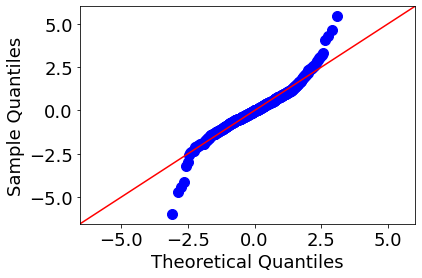

In [105]:
# 학습데이터의 잔차 확인
pred_y = fitted_full_model.predict(train_x)
res = fitted_full_model.resid  # residual

# q-q plot # 정규분포 확인
fig = sm.qqplot(res, fit=True, line='45')

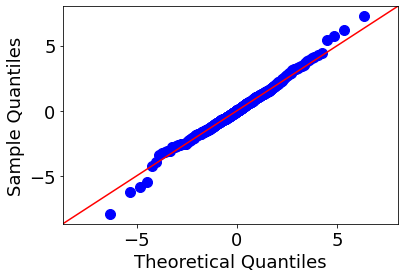

In [106]:
# 학습데이터의 잔차 확인
pred_y = fitted_full_model.predict(train_x)
res = fitted_full_model.resid  # residual

# q-q plot # 정규분포 확인
import scipy.stats as stats
fig = sm.qqplot(res, stats.t, fit=True, line='45')

### 이상관측치탐색

* Residuals: Y에서 벗어나는 정도
* Leverage: X에서 벗어나는 정도 

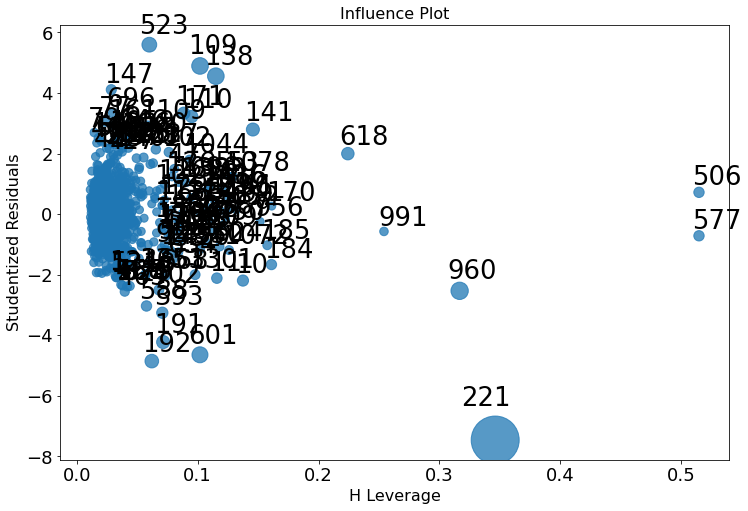

In [107]:
# Cook's distance with high leverage
fig, ax = plt.subplots(figsize=(12,8))
fig = sm.graphics.influence_plot(fitted_full_model, ax=ax, criterion="cooks", s=2)

### 잔차패턴확인

Text(0, 0.5, 'Residual')

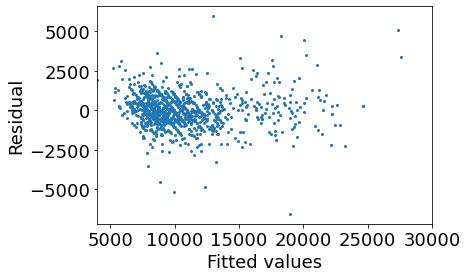

In [108]:
# residual pattern 확인
fig = plt.scatter(pred_y,res, s=4)
plt.xlim(4000,30000)
plt.xlim(4000,30000)
plt.xlabel('Fitted values')
plt.ylabel('Residual')

### **변수선택함수 정의**

### processSubset: 해당 feature_set에 대한 모델생성 및 AIC 계산

In [109]:
def processSubset(X,y, feature_set):
            model = sm.OLS(y,X[list(feature_set)]) # Modeling
            regr = model.fit() # 모델 학습
            AIC = regr.aic # 모델의 AIC
            return {"model":regr, "AIC":AIC}
        
print(processSubset(X=train_x, y=train_y, feature_set = feature_columns[0:5]))

{'model': <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x000001A0CE6666C8>, 'AIC': 19087.157001523432}


### getBest: 가장 높은 AIC를 가지는 모델 선택 및 저장

In [45]:
def getBest(X,y,k):
    tic = time.time() # 시작시간
    results = [] # 결과 저장공간
    for combo in itertools.combinations(X.columns.difference(['const']), k): # 각 변수조합을 고려한 경우의 수
        results.append(processSubset(X,y,feature_set=combo))  # 모델링된 것들을 저장
    models = pd.DataFrame(results) # 데이터 프레임으로 변환
    # 가장 낮은 AIC를 가지는 모델 선택 및 저장
    best_model = models.loc[models['AIC'].argmin()] # index
    toc = time.time() # 종료시간
    print("Processed ", models.shape[0], "models on", k, "predictors in", (toc - tic),
          "seconds.")
    return best_model

print(getBest(X=train_x, y=train_y,k=2))

Processed  630 models on 2 predictors in 1.111029863357544 seconds.
model    <statsmodels.regression.linear_model.Regressio...
AIC                                                17749.5
Name: 67, dtype: object


### 변수조합에 따른 모델링 시간

In [46]:
# 변수 선택에 따른 학습시간과 저장
models = pd.DataFrame(columns=["AIC", "model"])
tic = time.time()
for i in range(1,4):
    models.loc[i] = getBest(X=train_x,y=train_y,k=i)
toc = time.time()
print("Total elapsed time:", (toc-tic), "seconds.")

Processed  36 models on 1 predictors in 0.06382942199707031 seconds.
Processed  630 models on 2 predictors in 1.065185308456421 seconds.
Processed  7140 models on 3 predictors in 10.048228025436401 seconds.
Total elapsed time: 11.32484745979309 seconds.


In [47]:
models

,AIC,model
1,19181.920243,<statsmodels.regression.linear_model.Regressio...
2,17749.459401,<statsmodels.regression.linear_model.Regressio...
3,17513.372800,<statsmodels.regression.linear_model.Regressio...


## 모델평가 지표

In [48]:
models.loc[3, "model"].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  Price   R-squared (uncentered):                   0.983
Model:                            OLS   Adj. R-squared (uncentered):              0.983
Method:                 Least Squares   F-statistic:                          1.968e+04
Date:                Sun, 13 Jun 2021   Prob (F-statistic):                        0.00
Time:                        20:02:17   Log-Likelihood:                         -8753.7
No. Observations:                1005   AIC:                                  1.751e+04
Df Residuals:                    1002   BIC:                                  1.753e+04
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Age_08_04   -122.0081      2.720    -44.849      0.000    -127.347    -116.670
KM            -0.0240      0.001    -16.366      0.000      -0.027      -0.021
Weight        17.8840      0.127    140.733      0.000      17.635      18.133
==============================================================================
Omnibus:                      147.992   Durbin-Watson:                   1.992
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1509.008
Skew:                          -0.285   Prob(JB):                         0.00
Kurtosis:                       8.976   Cond. No.                     4.52e+03
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 4.52e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [49]:
# 모든 변수들 모델링 한것보다 나은 결과를 가져옴
print("selected model Rsquared: ","{:.5f}".format(models.loc[3, "model"].rsquared))
print("selected model AIC: ","{:.5f}".format(models.loc[3, "model"].aic))
print("selected model MSE: ","{:.5f}".format(models.loc[3, "model"].mse_total))

selected model Rsquared:  0.98331
selected model AIC:  17513.37280
selected model MSE:  129014650.45174


Text(0, 0.5, 'BIC')

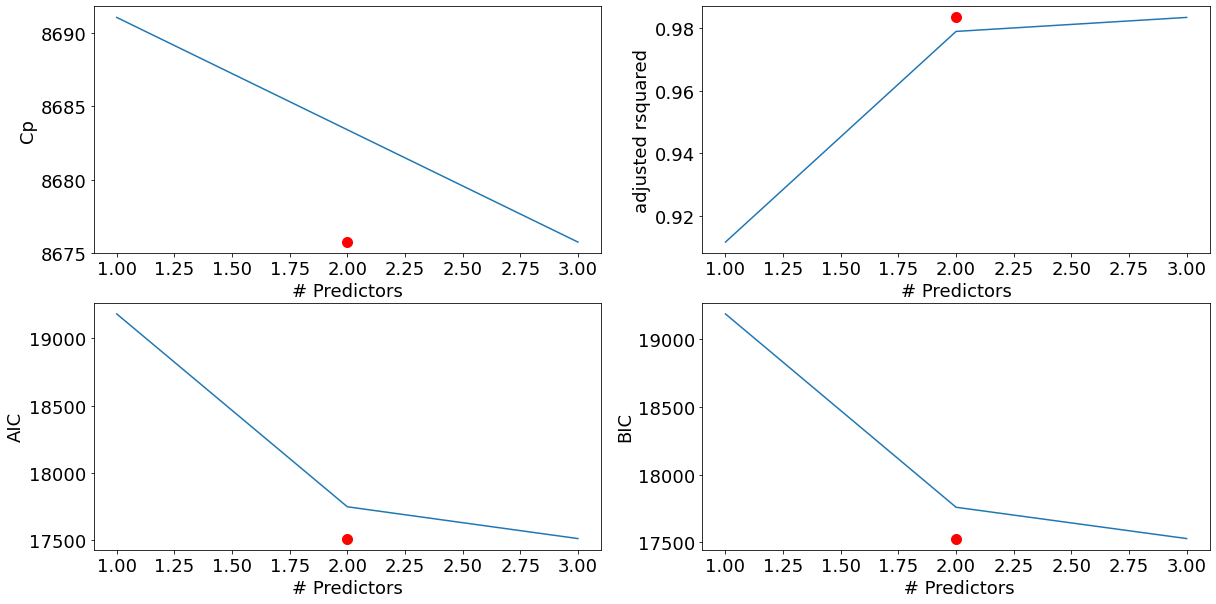

In [50]:
# Plot the result
plt.figure(figsize=(20,10))
plt.rcParams.update({'font.size': 18, 'lines.markersize': 10})

## Mallow Cp
plt.subplot(2, 2, 1)
Cp= models.apply(lambda row: (row[1].params.shape[0]+(row[1].mse_total-
                               fitted_full_model.mse_total)*(train_x.shape[0]-
                                row[1].params.shape[0])/fitted_full_model.mse_total
                               ), axis=1)
plt.plot(Cp)
plt.plot(Cp.argmin(), Cp.min(), "or")
plt.xlabel('# Predictors')
plt.ylabel('Cp')

# adj-rsquared plot
# adj-rsquared = Explained variation / Total variation
adj_rsquared = models.apply(lambda row: row[1].rsquared_adj, axis=1)
plt.subplot(2, 2, 2)
plt.plot(adj_rsquared)
plt.plot(adj_rsquared.argmax(), adj_rsquared.max(), "or")
plt.xlabel('# Predictors')
plt.ylabel('adjusted rsquared')

# aic
aic = models.apply(lambda row: row[1].aic, axis=1)
plt.subplot(2, 2, 3)
plt.plot(aic)
plt.plot(aic.argmin(), aic.min(), "or")
plt.xlabel('# Predictors')
plt.ylabel('AIC')

# bic
bic = models.apply(lambda row: row[1].bic, axis=1)
plt.subplot(2, 2, 4)
plt.plot(bic)
plt.plot(bic.argmin(), bic.min(), "or")
plt.xlabel(' # Predictors')
plt.ylabel('BIC')

## **전진선택법**

### forward: 전진선택법 (step=1)

In [51]:
def forward(X, y, predictors):
    # 데이터 변수들이 미리정의된 predictors에 있는지 없는지 확인 및 분류
    remaining_predictors = [p for p in X.columns.difference(['const']) if p not in predictors]
    tic = time.time()
    results = []
    for p in remaining_predictors:
        results.append(processSubset(X=X, y= y, feature_set=predictors+[p]+['const']))
    # 데이터프레임으로 변환
    models = pd.DataFrame(results)

    # AIC가 가장 낮은 것을 선택
    best_model = models.loc[models['AIC'].argmin()] # index
    toc = time.time()
    print("Processed ", models.shape[0], "models on", len(predictors)+1, "predictors in", (toc-tic))
    print('Selected predictors:',best_model['model'].model.exog_names,' AIC:',best_model[0] )
    return best_model

### forward_model: 전진선택법 모델

In [52]:
def forward_model(X,y):
    Fmodels = pd.DataFrame(columns=["AIC", "model"])
    tic = time.time()
    # 미리 정의된 데이터 변수
    predictors = []
    # 변수 1~10개 : 0~9 -> 1~10
    for i in range(1, len(X.columns.difference(['const'])) + 1):
        Forward_result = forward(X=X,y=y,predictors=predictors)
        if i > 1:
            if Forward_result['AIC'] > Fmodel_before:
                break
        Fmodels.loc[i] = Forward_result
        predictors = Fmodels.loc[i]["model"].model.exog_names
        Fmodel_before = Fmodels.loc[i]["AIC"]
        predictors = [ k for k in predictors if k != 'const']
    toc = time.time()
    print("Total elapsed time:", (toc - tic), "seconds.")

    return(Fmodels['model'][len(Fmodels['model'])])

In [53]:
Forward_best_model = forward_model(X=train_x, y= train_y)

Processed  36 models on 1 predictors in 0.05979156494140625
Selected predictors: ['Mfg_Year', 'const']  AIC: <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x000001A0C8995508>
Processed  35 models on 2 predictors in 0.06482577323913574
Selected predictors: ['Mfg_Year', 'Automatic_airco', 'const']  AIC: <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x000001A0C89A05C8>
Processed  34 models on 3 predictors in 0.057845354080200195
Selected predictors: ['Mfg_Year', 'Automatic_airco', 'HP', 'const']  AIC: <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x000001A0C8BF1688>
Processed  33 models on 4 predictors in 0.04886937141418457
Selected predictors: ['Mfg_Year', 'Automatic_airco', 'HP', 'Weight', 'const']  AIC: <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x000001A0C8928E08>
Processed  32 models on 5 predictors in 0.05485343933105469
Selected predictors: ['Mfg_Year', 'Automatic_airco', 'HP

In [54]:
Forward_best_model.aic

16972.719613484085

## **후진소거법**

### backward: 후진소거법(step=1)

In [55]:
def backward(X,y,predictors):
    tic = time.time()
    results = []
    # 데이터 변수들이 미리정의된 predictors 조합 확인
    for combo in itertools.combinations(predictors, len(predictors) - 1):
        results.append(processSubset(X=X, y= y,feature_set=list(combo)+['const']))
    models = pd.DataFrame(results)
    # 가장 낮은 AIC를 가진 모델을 선택
    best_model = models.loc[models['AIC'].argmin()]
    toc = time.time()
    print("Processed ", models.shape[0], "models on", len(predictors) - 1, "predictors in",
          (toc - tic))
    print('Selected predictors:',best_model['model'].model.exog_names,' AIC:',best_model[0] )
    return best_model

### backward: 후진소거법모델

In [56]:
def backward_model(X, y):
    Bmodels = pd.DataFrame(columns=["AIC", "model"], index = range(1,len(X.columns)))
    tic = time.time()
    predictors = X.columns.difference(['const'])
    Bmodel_before = processSubset(X,y,predictors)['AIC']
    while (len(predictors) > 1):
        Backward_result = backward(X=train_x, y= train_y, predictors = predictors)
        if Backward_result['AIC'] > Bmodel_before:
            break
        Bmodels.loc[len(predictors) - 1] = Backward_result
        predictors = Bmodels.loc[len(predictors) - 1]["model"].model.exog_names
        Bmodel_before = Backward_result['AIC']
        predictors = [ k for k in predictors if k != 'const']

    toc = time.time()
    print("Total elapsed time:", (toc - tic), "seconds.")
    return (Bmodels['model'].dropna().iloc[0])

In [57]:
Backward_best_model = backward_model(X=train_x,y=train_y)

Processed  36 models on 35 predictors in 0.10372138023376465
Selected predictors: ['ABS', 'Age_08_04', 'Airbag_1', 'Airbag_2', 'Airco', 'Automatic', 'Automatic_airco', 'BOVAG_Guarantee', 'Backseat_Divider', 'Boardcomputer', 'CD_Player', 'CNG', 'Central_Lock', 'Cylinders', 'Diesel', 'Doors', 'Gears', 'Guarantee_Period', 'HP', 'KM', 'Met_Color', 'Metallic_Rim', 'Mfg_Month', 'Mfg_Year', 'Mfr_Guarantee', 'Petrol', 'Power_Steering', 'Powered_Windows', 'Quarterly_Tax', 'Radio', 'Radio_cassette', 'Sport_Model', 'Tow_Bar', 'Weight', 'cc', 'const']  AIC: <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x000001A0C899BB08>
Processed  35 models on 34 predictors in 0.0967409610748291
Selected predictors: ['ABS', 'Age_08_04', 'Airbag_1', 'Airbag_2', 'Airco', 'Automatic', 'Automatic_airco', 'BOVAG_Guarantee', 'Backseat_Divider', 'Boardcomputer', 'CD_Player', 'CNG', 'Cylinders', 'Diesel', 'Doors', 'Gears', 'Guarantee_Period', 'HP', 'KM', 'Met_Color', 'Metallic_Rim', 'Mfg_Month'

In [58]:
Backward_best_model.aic

16972.71961348411

## **단계적 선택법**

### stepwise_model: 단계적 선택법 모델

In [59]:
def Stepwise_model(X,y):
    Stepmodels = pd.DataFrame(columns=["AIC", "model"])
    tic = time.time()
    predictors = []
    Smodel_before = processSubset(X,y,predictors+['const'])['AIC']
    # 변수 1~10개 : 0~9 -> 1~10
    for i in range(1, len(X.columns.difference(['const'])) + 1):
        Forward_result = forward(X=X, y=y, predictors=predictors) # constant added
        print('forward')
        Stepmodels.loc[i] = Forward_result
        predictors = Stepmodels.loc[i]["model"].model.exog_names
        predictors = [ k for k in predictors if k != 'const']
        Backward_result = backward(X=X, y=y, predictors=predictors)
        if Backward_result['AIC']< Forward_result['AIC']:
            Stepmodels.loc[i] = Backward_result
            predictors = Stepmodels.loc[i]["model"].model.exog_names
            Smodel_before = Stepmodels.loc[i]["AIC"]
            predictors = [ k for k in predictors if k != 'const']
            print('backward')
        if Stepmodels.loc[i]['AIC']> Smodel_before:
            break
        else:
            Smodel_before = Stepmodels.loc[i]["AIC"]
    toc = time.time()
    print("Total elapsed time:", (toc - tic), "seconds.")
    return (Stepmodels['model'][len(Stepmodels['model'])])

In [60]:
Stepwise_best_model=Stepwise_model(X=train_x,y=train_y)

Processed  36 models on 1 predictors in 0.05488872528076172
Selected predictors: ['Mfg_Year', 'const']  AIC: <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x000001A0C842F588>
forward
Processed  1 models on 0 predictors in 0.002992391586303711
Selected predictors: ['const']  AIC: <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x000001A0C88CF088>
Processed  35 models on 2 predictors in 0.044911861419677734
Selected predictors: ['Mfg_Year', 'Automatic_airco', 'const']  AIC: <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x000001A0C842F7C8>
forward
Processed  2 models on 1 predictors in 0.004986763000488281
Selected predictors: ['Mfg_Year', 'const']  AIC: <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x000001A0C88FC9C8>
Processed  34 models on 3 predictors in 0.04288458824157715
Selected predictors: ['Mfg_Year', 'Automatic_airco', 'HP', 'const']  AIC: <statsmodels.regression.linear_model.R

In [61]:
Stepwise_best_model.aic

16972.719613484085

# **성능평가**

In [62]:
# the number of params
print(Forward_best_model.params.shape, Backward_best_model.params.shape, Stepwise_best_model.params.shape)

(24,) (23,) (24,)


In [63]:
# 모델에 의해 예측된/추정된 값 <->  test_y
pred_y_full = fitted_full_model.predict(test_x)
pred_y_forward = Forward_best_model.predict(test_x[Forward_best_model.model.exog_names])
pred_y_backward = Backward_best_model.predict(test_x[Backward_best_model.model.exog_names])
pred_y_stepwise = Stepwise_best_model.predict(test_x[Stepwise_best_model.model.exog_names])

In [64]:
perf_mat = pd.DataFrame(columns=["ALL", "FORWARD", "BACKWARD", "STEPWISE"],
                        index =['MSE', 'RMSE','MAE', 'MAPE'])

In [65]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [66]:
# 성능지표
perf_mat.loc['MSE']['ALL'] = metrics.mean_squared_error(test_y,pred_y_full)
perf_mat.loc['MSE']['FORWARD'] = metrics.mean_squared_error(test_y,pred_y_forward)
perf_mat.loc['MSE']['BACKWARD'] = metrics.mean_squared_error(test_y,pred_y_backward)
perf_mat.loc['MSE']['STEPWISE'] = metrics.mean_squared_error(test_y,pred_y_stepwise)

perf_mat.loc['RMSE']['ALL'] = np.sqrt(metrics.mean_squared_error(test_y, pred_y_full))
perf_mat.loc['RMSE']['FORWARD'] = np.sqrt(metrics.mean_squared_error(test_y, pred_y_forward))
perf_mat.loc['RMSE']['BACKWARD'] = np.sqrt(metrics.mean_squared_error(test_y, pred_y_backward))
perf_mat.loc['RMSE']['STEPWISE'] = np.sqrt(metrics.mean_squared_error(test_y, pred_y_stepwise))

perf_mat.loc['MAE']['ALL'] = metrics.mean_absolute_error(test_y, pred_y_full)
perf_mat.loc['MAE']['FORWARD'] = metrics.mean_absolute_error(test_y, pred_y_forward)
perf_mat.loc['MAE']['BACKWARD'] = metrics.mean_absolute_error(test_y, pred_y_backward)
perf_mat.loc['MAE']['STEPWISE'] = metrics.mean_absolute_error(test_y, pred_y_stepwise)

perf_mat.loc['MAPE']['ALL'] = mean_absolute_percentage_error(test_y, pred_y_full)
perf_mat.loc['MAPE']['FORWARD'] = mean_absolute_percentage_error(test_y, pred_y_forward)
perf_mat.loc['MAPE']['BACKWARD'] = mean_absolute_percentage_error(test_y, pred_y_backward)
perf_mat.loc['MAPE']['STEPWISE'] = mean_absolute_percentage_error(test_y, pred_y_stepwise)

print(perf_mat)

              ALL      FORWARD     BACKWARD     STEPWISE
MSE   7.56418e+06  7.90926e+06  7.90926e+06  7.90926e+06
RMSE      2750.31      2812.34      2812.34      2812.34
MAE       923.469      929.928      929.928      929.928
MAPE       8.7147      8.76357      8.76357      8.76357



## **3. 유전알고리즘을 이용한 변수선택법 실습**

### **유전알고리즘을 이용한 변수선택법**

- feature-selection-ga: 파이썬 레포지토리에서 공개된 유전알고리즘기반 변수선택방법론 패키지  
https://featureselectionga.readthedocs.io/en/latest/

<img src = "./fig/5_featureselectionGA.PNG" width="60%">

In [67]:
#!pip install feature-selection-ga

In [68]:
from sklearn.datasets import make_classification
from sklearn import linear_model
from feature_selection_ga import FeatureSelectionGA, FitnessFunction

import warnings
warnings.filterwarnings('ignore')

<img src = "./fig/4_유전알고리즘학습절차.PNG" width="60%">

예제 데이터 생성
- classification 데이터셋을 생성, 15개의 변수로 구성된 데이터를 통해 3개 class를 예측하는 가상 데이터셋을 생성

In [69]:
X, y = make_classification(n_samples=100, n_features=15, n_classes=3,
                           n_informative=4, n_redundant=1, n_repeated=2,
                           random_state=1)

In [70]:
y

array([0, 0, 0, 2, 2, 1, 1, 2, 2, 0, 0, 1, 0, 2, 1, 1, 1, 2, 0, 0, 2, 2,
       1, 0, 1, 0, 0, 0, 2, 0, 0, 2, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 2,
       2, 1, 2, 1, 2, 2, 0, 2, 1, 2, 1, 1, 2, 1, 1, 2, 1, 2, 2, 0, 2, 1,
       1, 1, 2, 2, 2, 0, 0, 0, 0, 2, 1, 0, 2, 1, 2, 2, 2, 1, 0, 2, 0, 2,
       1, 0, 0, 0, 1, 1, 1, 2, 0, 0, 1, 2])

In [71]:
print('X shape: ',X.shape)
print('Y shape: ',y.shape)
print('Y class:', set(y))

X shape:  (100, 15)
Y shape:  (100,)
Y class: {0, 1, 2}


### 적합하고자하는 모델을 정의
- 적합하고자 하는 모델을 정의
- ```feature_selection_ga``` 패키지에서 제공하는 **FeatureSelectionGA()** 함수를 활용하여 유전알고리즘을 설정

In [72]:

model = linear_model.LogisticRegression(solver='lbfgs', multi_class='auto')
fsga = FeatureSelectionGA(model,X,y, ff_obj = FitnessFunction())



- 원하는 iteration 만큼 유전학습을 수행합니다.

최종적으로 마지막 iteration의 선택된 변수 index를 확인하여 선택된 index 기준의 변수를 확인합니다.

In [73]:
iter_num = 100
pop1 = fsga.generate(iter_num)

EVOLVING.......
-- GENERATION 1 --
Evaluated 60 individuals
-- GENERATION 2 --
Evaluated 63 individuals
-- GENERATION 3 --
Evaluated 64 individuals
-- GENERATION 4 --
Evaluated 62 individuals
-- GENERATION 5 --
Evaluated 65 individuals
-- Only the fittest survives --
Best individual is [0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0], (0.69,)


In [74]:
iter_num2 = 200
pop2 = fsga.generate(iter_num2)

EVOLVING.......
-- GENERATION 1 --
Evaluated 124 individuals
-- GENERATION 2 --
Evaluated 117 individuals
-- GENERATION 3 --
Evaluated 123 individuals
-- GENERATION 4 --
Evaluated 116 individuals
-- GENERATION 5 --
Evaluated 115 individuals
-- Only the fittest survives --
Best individual is [1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0], (0.71,)


In [75]:
print('After 100 iter:',pop1[-1])
print('After 200 iter:',pop2[-1])

After 100 iter: [1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0]
After 200 iter: [1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0]


##  Personal Loan 데이터셋을 통한 유전알고리즘 실습

로지스틱회귀분석을 기준으로 **1)전체 변수를 활용한 모델**과 **2)유전알고리즘을 통해 선택된 변수만을 활용한 모델**의 성능비교를 수행해봅시다.

데이터는 Personal Loan 데이터셋을 활용하도록 하겠습니다.
이전시간에 수행한 로지스틱회귀분석의 절차를 동일하게 수행해보도록 하겠습니다.

In [76]:
ploan = pd.read_csv("./data/Personal Loan.csv")
print( ploan.head(10) )

   ID  Age  Experience  Income  ZIP Code  Family  CCAvg  Education  Mortgage  \
0   1   25           1      49     91107       4    1.6          1         0   
1   2   45          19      34     90089       3    1.5          1         0   
2   3   39          15      11     94720       1    1.0          1         0   
3   4   35           9     100     94112       1    2.7          2         0   
4   5   35           8      45     91330       4    1.0          2         0   
5   6   37          13      29     92121       4    0.4          2       155   
6   7   53          27      72     91711       2    1.5          2         0   
7   8   50          24      22     93943       1    0.3          3         0   
8   9   35          10      81     90089       3    0.6          2       104   
9  10   34           9     180     93023       1    8.9          3         0   

   Personal Loan  Securities Account  CD Account  Online  CreditCard  
0              0                   1           0

In [77]:
feature_columns = list(ploan_processed.columns.difference(["Personal Loan"]))
X = ploan_processed[feature_columns]
y = ploan_processed['Personal Loan'] # 대출여부: 1 or 0

In [78]:
train_x, test_x, train_y, test_y = train_test_split(X, y, stratify=y,train_size=0.7,test_size=0.3,random_state=42)
print(train_x.shape, test_x.shape, train_y.shape, test_y.shape)

(1750, 12) (750, 12) (1750,) (750,)


In [79]:
train_y.values

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [80]:
train_x, test_x, train_y, test_y = train_x.values, test_x.values, train_y.values, test_y.values

#### personal loan 데이터셋을 기준으로 유전알고리즘을 통해 변수선택을 수행

In [81]:
model = linear_model.LogisticRegression(solver='lbfgs', multi_class='auto')
ploan_fsga = FeatureSelectionGA(model,train_x,train_y, ff_obj = FitnessFunction())

- iteraion은 100회를 수행

In [82]:
iter_num = 100
ploan_pop = ploan_fsga.generate(iter_num)

EVOLVING.......
-- GENERATION 1 --
Evaluated 61 individuals
-- GENERATION 2 --
Evaluated 63 individuals
-- GENERATION 3 --
Evaluated 45 individuals
-- GENERATION 4 --
Evaluated 55 individuals
-- GENERATION 5 --
Evaluated 58 individuals
-- Only the fittest survives --
Best individual is [0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0], (0.9514285714285714,)


최종적으로 마지막 iteration의 population을 확인

In [83]:
feature_idx = ploan_pop[-1]
print(feature_idx)

[0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0]


선택된 변수목록을 이진형으로 변환

In [84]:
feature_idx = [bool(i) for i in feature_idx]
feature_idx


[False, True, True, True, True, False, True, True, True, False, False, False]

유전알고리즘 학습결과 선택된 변수목록은 아래와 같습니다.

In [85]:
from itertools import compress
selected_features = list(compress(feature_columns, feature_idx))
print("Selected Features:",selected_features)


Selected Features: ['CCAvg', 'CD Account', 'CreditCard', 'Education', 'Family', 'Income', 'Mortgage']


선택된 변수를 기준으로 **축소된 학습데이터셋을 정의**합니다.


In [86]:
sel_train_x = train_x[:,feature_idx]
sel_test_x = test_x[:,feature_idx]

print("after selection train_x:",sel_train_x.shape)
print("after selection test_x:",sel_test_x.shape)


after selection train_x: (1750, 7)
after selection test_x: (750, 7)


비교를 위해 전체 변수를 모두 활용한 ```full_model```의 학습을 수행하고, 평가데이터에 대한 예측성능을 확인합니다.

In [87]:
full_model = linear_model.LogisticRegression(solver='lbfgs', multi_class='auto')
full_model.fit(train_x, train_y)

train_pred = full_model.predict(train_x)
test_pred = full_model.predict(test_x)

full_conf = confusion_matrix(test_y, test_pred)

In [88]:
print(f'학습 정오행렬 \n{confusion_matrix(train_y, train_pred)}')
print(f'테스트 정오행렬 \n{confusion_matrix(test_y, test_pred)}\n')
print(f'학습 정확도 : {accuracy_score(train_y, train_pred):.4f}')
print(f'테스트 정확도 : {accuracy_score(test_y, test_pred):.4f}')

학습 정오행렬 
[[1541   30]
 [  69  110]]
테스트 정오행렬 
[[665   8]
 [ 32  45]]

학습 정확도 : 0.9434
테스트 정확도 : 0.9467


유전알고리즘을 통해 선택된 변수들만을 활용한 ```ga_model```의 학습을 수행하고, 평가데이터에 대한 예측성능을 확인합니다.

In [89]:
ga_model = linear_model.LogisticRegression(solver='lbfgs', multi_class='auto')
ga_model.fit(sel_train_x, train_y)

train_pred_ga = ga_model.predict(sel_train_x)
test_pred_ga = ga_model.predict(sel_test_x)

ga_conf = confusion_matrix(test_y, test_pred_ga)

In [90]:
print(f'학습 정오행렬 \n{confusion_matrix(train_y, train_pred_ga)}')
print(f'테스트 정오행렬 \n{confusion_matrix(test_y, test_pred_ga)}\n')
print(f'학습 정확도 : {accuracy_score(train_y, train_pred_ga):.4f}')
print(f'테스트 정확도 : {accuracy_score(test_y, test_pred_ga):.4f}')

학습 정오행렬 
[[1549   22]
 [  62  117]]
테스트 정오행렬 
[[661  12]
 [ 31  46]]

학습 정확도 : 0.9520
테스트 정확도 : 0.9427


In [91]:
def perf_eval(cm):
    # True positive rate: TPR
    TPR = cm[1, 1] / sum(cm[1]) # recall
    # True negative rate: TNR
    TNR = cm[0, 0] / sum(cm[0])
    # Simple Accuracy
    ACC = (cm[0, 0] + cm[1, 1]) / sum(cm.reshape(-1,))
    # Balanced Correction Rate
    BCR = np.sqrt(TPR * TNR)
    # F1-measure
    Precision = cm[1,1] /sum(cm[:,1])
    F1 = 2*TPR*Precision/(TPR+Precision)
    return ([TPR, TNR, ACC, BCR, F1])

In [92]:
perf_mat = pd.DataFrame(columns=["TPR", "TNR", "ACC", "BCR","F1"],
                        index =['FULL', 'GA_Selection'])


perf_mat.loc['FULL']=perf_eval(full_conf)
perf_mat.loc['GA_Selection']=perf_eval(ga_conf)

perf_mat['Features'] = [train_x.shape[1],sel_train_x.shape[1]]

In [93]:
perf_mat

,TPR,TNR,ACC,BCR,F1,Features
FULL,0.584416,0.988113,0.946667,0.759914,0.692308,12
GA_Selection,0.597403,0.982169,0.942667,0.765996,0.681481,7
